This is a continuation of the <a href =online-gradient-descent.html>previous notes</a> on online learning and 
gradient descent. The plan is to have some actual example code here, and to analyze the <a href=http://jmlr.org/papers/v12/duchi11a.html>AdaGrad</a> algorithm. We'll do all this without resorting to more advanced notions such as duality or Bregman divergences. Finally, I'll propose an update to AdaGrad that makes the algorithm more robust to its sole remaining hyperparameter.

First of all, let's review the problem. We are going design an algorithm $L$ that plays the following game:

<ol>
For $t=1,\dots,T$
<li> $L$ outputs a vector $w_t\in S$, where $S$ is some given <i>convex</i> set.</li>
<li> The environment provides a <a href=https://en.wikipedia.org/wiki/Convex_function><i>convex</i></a> loss function $f_t:S\to \R$.</li>
<li> $L$ suffers loss $f_t(w_t)$
</ol>

The algorithm $L$ should pick $w_t$ in such a way as to minimize $\sum_{t=1}^T f_t(w_t)$. We make no assumptions about how the environment picks the functions $f_t$ - it could be actively trying to make $L$ do poorly (think email spam or credit card fraud detection). If the environment tries to make life difficult for $L$, it can easily guarantee that the overall loss $\sum_{t=1}^T f_t(w_t)$ is arbitrarily large. Thus instead of measuring this value, we instead measure the performance of $L$ using the quantity <i>regret</i>. The regret with respect to a fixed vector $w$ or a given set $U$ is defined as:
$$
\text{Regret}_T(w) = \sum_{t=1}^T f_t(w_t)-\sum_{t=1}^T f_t(w)\\
\text{Regret}_T(U) = \sum_{t=1}^T f_t(w_t)-\inf_{w^*\in U}\sum_{t=1}^Tf_t(w^*)
$$

We'll also write $\text{Regret}_T(L,U)$ to denote the regret of the learner $L$ with respect to the set $U$ when the choice of learner is not clear from context. 
For more detail/motivation about these definitions, check out the <a href =online-gradient-descent.html>previous post</a>. Before moving on, we'll need one important fact:

<div class = "theorem">
<h4>Proposition 1</h4>
Suppose $L$ is an algorithm such that when each loss function $f_t$ is linear - $f_t(w)=\langle z_t,w\rangle$, then $L$ suffers regret $\text{LinearRegret}_T(z_1,\dots,z_T)$. Let $L'$ be the learning algorithm that does the following:

<ol>
<li>$w_1' = w_1$, where $w_1$ is the first vector predicted by $L$. </li>
For $t=1,\dots,T$:
<li> Output $w_t'$, recieve $f_t'$ and suffer loss $f_t'(w_t')$
<li> Let $z_t$ be a subgradient of $f_t'$ at $w_t'$.</li>
<li> Send the function $f_t(w)=\langle z_t,w\rangle$ to $L$ and recieve $w_{t+1}$ from $L$.</li>
<li> Set $w_{t+1}'=w_{t+1}$. </li>
</ol>

In other words, $L'$ just runs $L$ on the sequence of subgradients it receives. Then 

$$
\text{Regret}_T(L',S)\le \text{LinearRegret}_T(z_1,\dots,z_T)
$$
for any set $S$.
</div>

The proof follows immediately from the definition of subgradient:

Since $f_t'$ is convex for all $t$ and $z_t$ is a subgradient of $f_t'$ at $w_t'$, we have
$$
f_t'(w_t')-f_t'(u)\le \langle w_t'-u',z_t\rangle=\langle w_t',z_t\rangle-\langle u',z_t\rangle
$$
$$
\text{Regret}_T(u) \le \sum_{t=1}^T \langle w_t',z_t\rangle -\langle u',z_t\rangle=\text{LinearRegret}_T(z_1,\dots,z_T)
$$

This proposition tells us that linear functions are in some sense the <i>hardest</i> functions to learn - an algorithm that does well on linear functions does just as well when run on subgradients of convex functions.

<h3>Regret with General Learning Rates</h3>

Now let's review Zinkevitch's online gradient descent algorithm. In the previous post we required a learning rate of the form $\frac{\alpha}{\sqrt{t}}$, but now we'll write the algorithm with an arbitrary learning rate $\eta_t$:

<div class = "algorithm">
<h4>Online Gradient Descent:</h4>
<ol>
<li>Input: Convex set $S$</li>
<li> Initialize $x_1=0$, $w_1=\Pi_S(x_1)$.
<br>
For each $t=1,2,\dots$</li>
<li> Predict $w_t=\Pi_S(x_t)$.</li>
<li> Receive subgradient $z_t$.</li>
<li> Update $x_{t+1}=w_t-\eta_t z_t$.</li>
</ol>
</div>

Now we can run through a derivation of the regret of this algorithm. First, note that the regret is bounded by the regret on the linear functions $\langle z_t,w\rangle$, so we need only bound the regret with respect to the subgradients $z_t$. 

Suppose $w^*\in S$. Since $w_{t+1}=\Pi_S(x_{t+1})$, we have $(w_{t+1}-w^*)^2\le (x_{t+1}-w^*)^2$. Therefore:
$$
\begin{align*}
x_{t+1}-w^*&=w_t-\eta_t z_t-w^*\\
(x_{t+1}-w^*)^2&=(w_t-\eta_t z_t-w^*)^2\\
(w_{t+1}-w^*)^2&\le(w_t-\eta_t z_t-w^*)^2\\
2\eta_tz_t(w_t-w^*)&\le (w_t-w^*)^2-(w_{t+1}-w^*)^2+\eta_t^2z_t^2\\
z_t(w_t-w^*)&\le \frac{1}{2\eta_t}\left((w_t-w^*)^2-(w_{t+1}-w^*)^2\right)+\frac{\eta_t}{2}z_t^2
\end{align*}
$$
Now the LHS is just the loss at $w_t$ minus the loss at $w^*$, so summing both sides over $T$ gives the regret:
$$
\begin{align*}
\text{Regret}_T(w^*) &\le \sum_{t=1}^T\frac{1}{2\eta_t}\left((w_t-w^*)^2-(w_{t+1}-w^*)^2\right)+\frac{\eta_t}{2}z_t^2\\
&\le \frac{1}{2\eta_1}(w_1-w^*)^2-\frac{1}{2\eta_T}(w_{T+1}-w^*)^2\\
&\ \ \ +\sum_{t=2}^T\left(\frac{1}{2\eta_t}-\frac{1}{2\eta_{t-1}}\right)(w_t-w^*)^2+\sum_{t=1}^T\frac{\eta_t}{2}z_t^2\\
\end{align*}
$$

Now suppose $\eta_t\le \eta_{t-1}$  and suppose $D$ is the diameter of the set $S$ so that $(w_t-w^*)^2\le D^2$ for all $t$. Then 
$$
\left(\frac{1}{2\eta_t}-\frac{1}{2\eta_{t-1}}\right)(w_t-w^*)^2\le \left(\frac{1}{2\eta_t}-\frac{1}{2\eta_{t-1}}\right)D^2
$$
and so we can telescope the first sum to obtain:

$$
\text{Regret}_T(w^*) \le \frac{1}{2\eta_1}(w_1-w^*)^2+\left(\frac{1}{2\eta_T}-\frac{1}{2\eta_1}\right) D^2 -\frac{1}{2\eta_T}(w_{T+1}-w^*)^2+\sum_{t=1}^T\frac{\eta_t}{2}z_t^2
$$

Now suppose our feasible set is the sphere of radius $\frac{D}{2}$. Then $L^2= \sum_{t=1}^T z_t^2$, $\eta_t = \frac{D}{2L}$ and $w_1=0$. Then since $\eta_T = \eta_1$ and $(w_1-w^*)^2\le \frac{D^2}{4}$, we have:

$$
\text{Regret}_T\left(\|w^*\|\le \frac{D}{2}\right) \le \frac{DL}{4}+\frac{DL}{4}=\frac{DL}{2}
$$
It can be <a href=http://www.eecs.berkeley.edu/Pubs/TechRpts/2008/EECS-2008-19.pdf>shown</a> that this bound is actually tight. That is, if we assume the environment is truly antagonistic, then it is impossible to achieve better regret.

Since in general we don't know that the feasible set is a sphere, we can instead write the regret bound in the form:

$$
\text{Regret}_T(w^*)\le \frac{1}{2\eta_T} D^2-\frac{1}{2\eta_T}(w_{T+1}-w^*)^2+\sum_{t=1}^T\frac{\eta_t}{2}z_t^2\\
\le \frac{1}{2\eta_T}D^2+\sum_{t=1}^T\frac{\eta_t}{2}z_t^2
$$


Let's write some code. Here is online gradient descent with a fixed stepsize:

In [9]:
# <!-- collapse=True -->
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from sklearn.datasets import load_digits,load_boston,load_diabetes,load_iris
%matplotlib inline  

In [10]:
# <!-- collapse=False -->
def ogd(winit,lossandgrad,step,T):
    """runs T steps of online gradient descent
    
            winit: vector in R^n, used for initial prediction
            lossandgrad: a function taking two arguments:
                    lossandgrad(w,t) where w is the current prediction and t is the iteration number.
                    should return l,g where l is the loss and g is the gradient
            step: stepsize multiplier."""
    w = np.copy(winit)
    totloss = 0
    loss = np.zeros(T)
    for t in xrange(T):
        l,g = lossandgrad(w,t)
        totloss += l
        w = w - step*g
        loss[t]=totloss/(t+1)
    return {"loss":loss}

Let's test this out on some of <a href=http://scikit-learn.org/stable/datasets/index.html>scikit-learn's toy datasets</a>. We'll just use linear classification for every problem. For the regression problems we'll attempt to minimize the squared error, and for classification we'll use the <a href=https://en.wikipedia.org/wiki/Hinge_loss>hinge loss</a>.

In [11]:
# <!-- collapse=False -->
def multiclasshinge(w,x,y):
    """computes multiclass hinge loss and its gradient
    
        
        w: input prediction matrix
        x: input example to predict class for
        y: target class"""
    pred = np.dot(w,x)
    
    #grab the largest prediction not equal to the correct class:
    ps = list(np.argsort(pred))
    ps.remove(y)
    p = ps[-1] 
    
    grad = np.zeros(np.shape(w))
    loss = max(0,1+pred[p]-pred[y])
    if(loss != 0):
        grad[p] = np.copy(x)
        grad[y] = np.copy(-x)
    return loss,grad

def l2loss(w,x,y):
    """computes squared error (w*x-y)^2 and its gradient with respect to w"""
    pred = np.dot(w,x)
    loss = 0.5*(pred-y)**2
    grad = (pred-y)*x
    return loss,grad

Now we'll load some datasets. The datasets are:

<ol>
<li><a href=http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits>digits</a>: a set of handwritten digits (like a smaller <a href=http://yann.lecun.com/exdb/mnist/>MNIST</a>).</li>
<li><a href=http://archive.ics.uci.edu/ml/datasets/Housing>boston</a>: some Boston housing data. The task is to predict the price of a house given features about its location.</li>
<li><a href=http://archive.ics.uci.edu/ml/datasets/Iris>Iris</a>: A classic dataset in which one attempts to predict the type of iris plant from various characteristics.</li>
<li><a href=http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html>diabetes</a>: A set of physiological measurements of diabetic patients. The task is to predict a score of disease progression.</li>
</ol>

Again, we're going to apply linear regression/classification to all these datasets. This may not achieve the best error, but we're more interested in watching online algorithms converge so this should be good enough for that.

The next couple of code blocks load in the datasets and define some functions for calculating losses and plotting the performance of algorithms. You don't need to read them to understand what's happening, unless you want to. In general I'll leave all the plotting code collapsed.

In [12]:
# <!-- collapse=True -->
classes = 10
digits = load_digits(classes)
boston = load_boston()
diabetes = load_diabetes()
iris = load_iris()

In [13]:
# <!-- collapse=True -->
def hingeloss(w,t,digits):
    l = len(digits.target)
    v = np.random.random_integers(0,l-1)
    y = digits.target[v]#*2-1
    x = np.append(digits.data[v].flatten(),1)
    return multiclasshinge(w,x,y)

def regloss(w,t,regdata):
    l = len(regdata.target)
    v = np.random.random_integers(0,l-1)
    y = regdata.target[v]
    x = np.append(regdata.data[v],1)
    return l2loss(w,x,y)

datasets = {}
ogdsteps = {}

imagelossgrad = lambda w,t:hingeloss(w,t,digits)
imagewinit = np.zeros((classes,1+len(digits.images[0].flatten())))
datasets["digits"] = (imagelossgrad,imagewinit,len(digits.target))

irislossgrad = lambda w,t:hingeloss(w,t,iris)
iriswinit = np.zeros((3,1+len(iris.data[0].flatten())))
datasets["iris"] = (irislossgrad,iriswinit,len(iris.target))

bostonlossgrad = lambda w,t:regloss(w,t,boston)
bostonwinit = np.zeros(len(boston.data[0])+1)
datasets["housing"] = (bostonlossgrad,bostonwinit,len(boston.target))

diabeteslossgrad = lambda w,t:regloss(w,t,diabetes)
diabeteswinit = np.zeros(len(diabetes.data[0])+1) 
datasets["diabetes"] = (diabeteslossgrad,diabeteswinit,len(diabetes.target))


ogdsteps["digits"] = [0.01,0.001,0.0001,0.00001,0.000001]
ogdsteps["iris"] = [1.0,0.1,0.01,0.001,0.0001]
ogdsteps["housing"] = [0.0000033,0.000001,0.0000001,0.00000001]
ogdsteps["diabetes"] = [1.5,1,0.1,0.01,0.001]

In [55]:
# <!-- collapse=True -->
def plotalgorithms(datasets,algs,passes=20,steplabels = True):
    """runs learning algorithms on datasets and plots losses. Can be used to compare algorithms.
    
        datasets: dictionary of datasets, keys are the names of the datasets
        algs: list of tuples of the form (alg,algname,steps,color)
                alg: learning algorithm. Takes an initial vector, loss function, stepsize and number of steps.
                steps: either dictionary containing stepsizes for different datasets or a list of 
                            stepsizes to use across all datasets
                color: If we are going to label all loss curves for a given algorithm with the same color
                            then this is the color for this algorithm. 
        passes: make len(dataset)*passes iterations on each dataset
        steplabels: if True, show all curves as a different color and give the stepsize in the legend.
                    if False, show all curves as the color associated with the algorithm and only show
                        the correspondence between color and algorithm in the legend."""
    
    fig = plt.figure(figsize=(12,10))
    axes = []
    for index in xrange(len(datasets.keys())):
        name = datasets.keys()[index]
        ax = fig.add_subplot(2,2,index)
        axes.append(ax)
        titleprefix = ""
        lines = []
        names = []
        for alg,algname,steps,color in algs:
            lines.append(mlines.Line2D([], [], color=color,
                          markersize=15, label=algname))
            names.append(algname)
            if(type(steps)==dict):
                steplist = steps[name]
            else:
                steplist = steps
            for stepval in  steplist:
                lossandgrad = datasets[name][0]
                winit = datasets[name][1]
                lendata = datasets[name][2]
                if(type(passes) == dict):
                    p = passes[name]
                else:
                    p = passes
                    
                loss = alg(winit,lossandgrad,stepval,p*lendata)["loss"]
                if(steplabels):
                    ax.plot(loss,label = "stepsize: "+str(stepval))
                else:
                    ax.plot(loss,label = "stepsize: "+str(stepval),color=color)
            if(titleprefix == ""):
                titleprefix = algname
            else:
                titleprefix = titleprefix+ " vs "+algname
                
        ax.tick_params(labelsize='small')
        ax.set_yscale('log')
        ax.set_title(titleprefix+" on "+name)
        if(steplabels):
            ax.legend()
        else:
            ax.legend(lines,names)

    ax = axes[1]  
    ax.set_ylabel("Average Loss")
    ax = axes[3]  
    ax.set_ylabel("Average Loss")
    ax.set_xlabel("t")
    ax = axes[0] 
    ax.set_xlabel("t")
        
    plt.show()

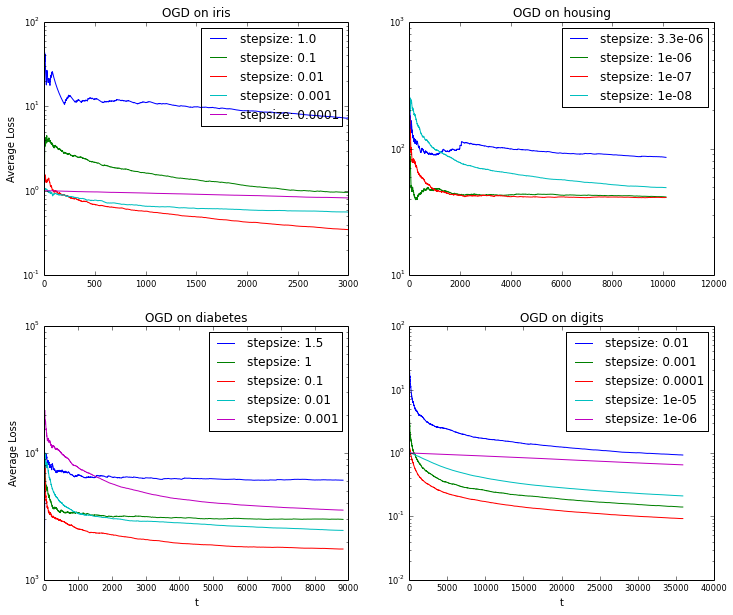

In [15]:
# <!-- collapse=True -->
plotalgorithms(datasets,[(ogd,"OGD",ogdsteps,'red')])

These learning rates were carefully picked to look fairly nice; if we make some of them a little too big, we get the following graphs instead:

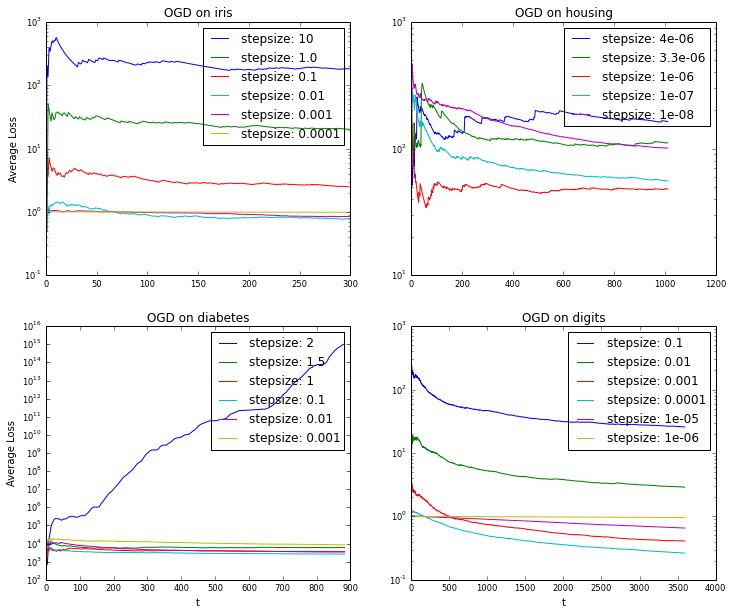

In [16]:
# <!-- collapse=True -->
ogdsteps["diabetes"] = [2]+ogdsteps["diabetes"]
ogdsteps["housing"] = [4*10**(-6)]+ogdsteps["housing"]
ogdsteps["iris"] = [10]+ogdsteps["iris"]
ogdsteps["digits"] = [0.1]+ogdsteps["digits"]
plotalgorithms(datasets,[(ogd,"OGD",ogdsteps,'red')],passes=2)

As you can see, the performance of online gradient descent is strongly dependent on choosing a good step size - if it's too small then we take forever to get anywhere and if it's too big then we run the risk being unable to stabilize around a "good" point. The process of picking step sizes (called hyperparameter tuning) is a kind of black-art in machine learning. To get these graphs, I had to look at a number of ranges of hyperparameters in order to find a set that would contain the best learning rate.



<h3>Better Stepsize Selection with AdaGrad</h3>

Unfortunately, it's not actually possible to set the optimal value of $\eta$ at the beginning since this requires knowledge of all the $z_t$ in advance. Fortunately, if one is sufficiently clever this is a surmountable problem. Set $L_t^2 = \sum_{t'=1}^t z_t^2$, and set $\eta_t = \frac{D}{\sqrt{2}L_t}$. Then

$$
\text{Regret}_T(w^*) \le\frac{\sqrt{2}DL}{2} +\sum_{t=1}^T \frac{\eta_t}{2}z_t^2
$$
To analyze the second term, we'll need a small lemma:

<div class="theorem">
<h4>Lemma 1</h4>
For any sequence of nonnegative numbers $a_1,\dots,a_T$,
$$
\sum_{t=1}^T \frac{a_t}{\sqrt{\sum_{t'=1}^t a_t}}\le 2\sqrt{\sum_{t=1}^T a_t}
$$
</div>

We prove this by induction on $T$. It is clearly true for $T=1$. Suppose it holds for $T-1$. Then note that since the square root function is concave, for any positive $x,y$ with $x-y\ge 0$, $\sqrt{x-y}\le \sqrt{x}-\frac{y}{2\sqrt{x}}$. Thus
$$
\sum_{t=1}^T \frac{a_t}{\sqrt{\sum_{t'=1}^t a_t}}\le 2\sqrt{\sum_{t=1}^{T-1} a_t} +\frac{a_T}{\sqrt{\sum_{t=1}^T a_t}}\\
\le 2\sqrt{\sum_{t=1}^T a_t}-2\frac{a_T}{2\sqrt{\sum_{t=1}^T a_T}}+\frac{a_T}{\sqrt{\sum_{t=1}^T a_t}}=2\sqrt{\sum_{t=1}^T a_t}
$$

Applying this lemma, we obtain

$$
\text{Regret}_T(w^*) \le\frac{\sqrt{2}DL}{2} +\frac{DL}{\sqrt{2}}=\sqrt{2}DL
$$

This is already pretty cool - we're losing only a factor of $\sqrt{2}$ over the optimal strategy. But it gets better: notice that the regret on linear functions can be written as the sum of the regrets across dimensions:
$$
\sum_{t=1}^T \langle z_t,w_t-u\rangle = \sum_{i=1}^d \sum_{t=1}^T z_{t,i}(w_{t,i}-u_{i})
$$
so that an algorithm that achieves low regret with respect to <i>one-dimensional</i> linear losses can be transformed into an algorithm that achieves low regret with respect to $d$-dimensional linear losses by running a seperate copy of the algorithm for each dimension. The total regret will be the sum of the regrets at each dimension.

Thus for each dimension we keep a seperate learning rate $\eta_{t,i}=\frac{D_i}{\sqrt{2\sum_{t'=1}^tz_{t,i}^2}}$, where $D_i$ is the diameter of $S$ projected along the $i$th coordinate axis. Then the regret at dimension $i$ will be
$$
\text{Regret}_{T,i} \le \sqrt{2} D_i\sqrt{\sum_{t=1}^T z_{t,i}^2}
$$
So that the overall regret is
$$
\text{Regret}_T\le \sqrt{2} \sum_{i=1}^d D_i\sqrt{\sum_{t=1}^T z_{t,i}^2}
$$

Now suppose $S$ is a box - $S=[a_1,b_1]\times\dots\times[a_d,b_d]$. Then $D_i = b_i-a_i$, and the diameter of $S$ is $D=\sqrt{\sum_{i=1}^d D_i^2}$. Applying the Cauchy-Schwarz inequality to our sum over dimensions gives

$$
\text{Regret}_T\le \sqrt{2}D\sqrt{\sum_{t=1}^T z_t^2}
$$
so that in this case our regret bound is no worse than it was before. However, whenever the Cauchy-Schwarz inequality is strict, then we should expect to do even better than this bound. This per-coordinate update is known as <a href=http://jmlr.org/papers/v12/duchi11a.html>AdaGrad</a>. The exposition here is more elementary (and corresponding less general) than in the Duchi et al. paper - it is more similar to that of <a href=http://arxiv.org/abs/1002.4908>McMahan and Streeter</a>.

So let's implement AdaGrad and run it on the same datasets as online gradient descent:

In [17]:
# <!-- collapse=False -->
def adagrad(winit,lossandgrad,step,T):
    """runs T steps of adagrad
    
            winit: vector in R^n, used for initial prediction
            lossandgrad: a function taking two arguments:
                    lossandgrad(w,t) where w is the current prediction and t is the iteration number.
                    should return l,g where l is the loss and g is the gradient
            step: stepsize multiplier."""
    w = np.copy(winit)
    L = 0.00000001 #set this to a small value to deal with divide-by-zero errors
    totloss = 0
    loss = np.zeros(T)
    for t in xrange(T):
        l,g = lossandgrad(w,t)
        totloss += l
        L += g**2
        w = w - step/(np.sqrt(L)*np.sqrt(2))*g
        loss[t]=totloss/(t+1)
    return {"loss":loss}

This snippet may also help illustrate how simple these methods are - AdaGrad is literally only a couple lines longer than vanilla gradient descent.

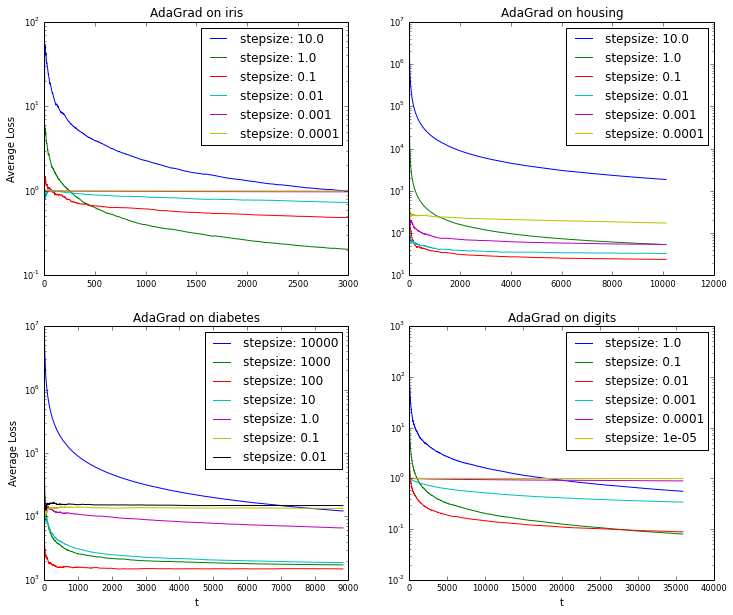

In [18]:
# <!-- collapse=True -->
adagradsteps = {}
adagradsteps["digits"] = [1.0,0.1,0.01,0.001,0.0001,0.00001]
adagradsteps["iris"] = [10.0,1.0,0.1,0.01,0.001,0.0001]
adagradsteps["housing"] = [10.0,1.0,0.1,0.01,0.001,0.0001]
adagradsteps["diabetes"] = [10000,1000,100,10,1.0,0.1,0.01]
plotalgorithms(datasets,[(adagrad,"AdaGrad",adagradsteps,'red')])

Here I've had to re-adjust the parameter ranges from OGD, and clearly there is still a strong dependence on the initial learning rate. However, notice that we no longer have the bad behavior on the Housing and Diabetes datasets in which our loss was made to increase when the learning rate was too high. This suggests that such instability is caused by uncontrolled fluctuations in the gradients which the adaptive step size in AdaGrad can compensate for.

<h3>Removing the Last Hyperparameter</h3>

We've seen that both of the previous methods are dependent on some step size scaling. The ordinary gradient descent depended on both an estimate of the size of the search space $D$ and the size of the gradients $L$. AdaGrad learns $L$ on the fly, but still needs to be told $D$ (or $D_i$). Can we get rid of this requirement too?

In the case in which the set $S$ is some known bounded set and we are considering arbitrarily evil loss functions, then not only is it actually easy to specify $D$ (since $S$ is a known set), but it's probably actually necessary since the arbitrariness of the loss functions may cause havok with any attempt to learn $D$ on-the-fly.

However, in reality it is likely that neither of these conditions are true. We may not really know how big $S$ is and so just allow $S=\R^d$ (as we did in all the examples above). Further, the loss functions are often not arbitrarily bad - in general we can expect that they will in a sense enforce a bound on $S$ by going to infinity for sufficiently large inputs. In this case we need to guess a value of $D$ that is "big enough" to contain the optimal point $w^*$, but not so big as to waste time exploring too much area.

It is true that choosing any arbitrary $D$ will still result in sub-linear regret, but ideally we'd like to achieve a constant multiple of $D^*\sqrt{\sum_{t=1}^T z_t^2}$ where $D^*$ is twice the norm of the optimal point $w^*$.

Let's try to solve this problem. Using our observation that we can reduce $d$-dimensional online convex optimization to $1$-dimensional online linear optimization, we'll just try to solve the problem for the 1-d linear case. As a first step, we'll set up an additional assumption that makes the problem tractable:


<ul>
<li> Assume there is some $B^*$ such that $f_t$ achieves its minimum at some $w_{f_t}$ with $|w_{f_t}|\le B^*$ for all $t$.</li>
</ul>

This assumption specifies an "effective domain" of diameter $D^*=2B^*$ since for all $t$ we have $\|w^*_t\|\le B^*$ Therefore our goal is to find an algorithm $L$ such that

$$
\text{Regret}_T(L) \le K\left[D^*\sqrt{\sum_{t=1}^T z_t^2}\right]
$$

where $z_t$ are the subgradients recieved by the algorithm and $K$ is some function that depends only mildly on any misspecification of hyperparameters. We'll achieve $K$ that depends on the square root of the logarithm of the ratio between an initial guess for $B^*$ and the true value.

that does not grow with $T$ and $K$ is an absolute constant (a number). Ideally, $C$ would have very little dependence on hyperparameters as well. We'll achieve a $C$ with only a logarithmic dependence the ratio between an initial guess for $B^*$ and the true value.

In other words, we want our algorithm to close to optimal for a wide variety or parameter choices. Note that if we know $B^*$ in advance, then AdaGrad can achieve a constant of $K=\sqrt{2}$. However, since we do not in fact know $B^*$, we'd have to make a guess. In this case if we use AdaGrad $K$ will depend on the ratio between $B^*$ and our guess, which is not what we want.

Notice that AdaGrad has the interesting property that the value of $\|w_{t+1}-w_t\|$ is always at most a constant independent of $t$. This property creates quite a bit of stability in our prediction vectors, which we will exploit to explore possible guesses for $B^*$ while guaranteeing that we stabilize to a good estimate.

The algorithm (on one-dimensional inputs) is as follows:

<div class = "algorithm">
<h4>Adaptive $B$ AdaGrad:</h4>

<ol>
Input: $B_1$, an under-estimate of $B^*$.
<li>Initialize $w_1=0$, $L_0=0$.</li>
For $t=1,\dots, T$:
<li>Output $w_t$, recieve subgradient $z_t$.</li>
<li>Update $L_t^2 = L_{t-1}^2 + z_t^2$.</li>
<li>Set $w_{t+1} = w_t - \alpha \frac{B_t}{L_t}z_t$.</li>
If $|w_{t+1}|>(1+\alpha)B_t$:
<li>Set $B_{t+1} = (1+\alpha)B_t$ and set $L_{t}=0$.</li>
Else:
<li> Set $B_{t+1}=B_t$
</ol>
</div>

This looks somewhat complicated, but the principle is not too difficult to grasp. Effectively, we are maintaining a value $B_t$ that we hope should satisfy $ B_t\le (1+\alpha)B^*$. Initially $B_t$ is too small, but over time we make it larger as necessary, restarting our AdaGrad estimate of $L$ every time we update $B_t$. Since $B_t$ grows geometrically on every update, we should only need a logarithmic number of restarts.

<h3>Regret of Adaptive $B$ AdaGrad</h3>

To analyze this algorithm we'll first show that $B_t\le(1+\alpha)B^*$ for all $t$. Then we'll bound the regret incurred during periods of fixed $B$ values, after which we'll put both of these facts together to obtain a complete regret bound.

<h4>$B_t\le (1+\alpha)B^*$ for all $t$:</h4>

Note that $L_t \ge |z_t|$ for all $t$ so that $|w_{t+1}-w_t|\le \alpha B_t$. Using this we can show that for all $t$, $|w_t|\le (1+\alpha)B_{t}$. We proceed by induction on $t$. For $t=1$ the statement is true from the initialization. Suppose it is true for $t-1\ge 1$. Then $|w_{t-1}|\le (1+\alpha)B_{t-1}$, and since $|w_t-w_{t-1}|\le \alpha B_{t-1}$, we have $|w_t|\le (1+2\alpha) B_{t-1}$. Now if $|w_t|\le (1+\alpha) B_{t-1}$, then we are done since $B_{t-1}\le B_t$. Otherwise, $B_t=(1+\alpha)B_{t-1}$ and so $(1+2\alpha) B_{t-1}\le (1+\alpha)^2B_{t-1}=(1+\alpha) B_t$.

Now suppose $B_{t+1}> B_t$ for some $t$. Then since $|w_t|\le (1+\alpha) B_t$ and $|w_{t+1}-w_t|\le \alpha B_t$, we must have $|w_t|> B_t$, and $z_t$ and $w_t$ must have opposite signs. However, if $|w_t|> B^*$, then the sign of $z_t$ and $w_t$ must agree (assumption 1). Therefore if $B_{t+1}>B_t$, then $B_t\le B^*$. Since $B_{t+1}>B_t$ implies $B_t\le B_*$, we must have $B_t\le (1+\alpha) B^*$ for all $t$.

<h4>Bounding Regret Across a Fixed $B_t$</h4>

Consider some range of $t$ values, $t=t_1,\dots,t_2$ such that $B_{t_1}=B_{t_2}=B$ with $(1+\alpha)B\le B^*$. We'll bound the quantity

$$
R_{t_1,t_2}= \sum_{t=t_1}^{t_2-1} f_t(w_t) - f_t(w^*)
$$

where $w^*= \argmin \sum_{t=t_1}^{t_2-1} f_t$.

We'll consider two cases. The first is the case that $\|w^*\|\ge (1+2\alpha)B$. The second case is, naturally, $\|w^*\|<(1+2\alpha)B$.

<h5> Case 1: $\|w^*\|\ge (1+2\alpha)B$: </h5>

For the first case, notice that in Zinkevich's proof of the online gradient descent regret bound one ends up with an expression

$$
\text{Regret}_T \le \frac{D^2}{2\eta_T}-\frac{(w_{T+1}-w^*)^2}{2\eta_T} + \sum_{t=1}^T \frac{\eta_t}{2}z_t^2
$$

where $(w_t-w^*)^2\le D^2$ for all $t$. Now normally we just neglect the negative term since it's at most $0$. However, in this case we actually have a little more information and so we'll be able to make use of it. In particular, we have $D= \|w^*\| + (1+\alpha)B$ since we know $\|w_t\|\le (1+\alpha)B$ for all $t\in[t_1,t_2]$. We also know $(w_{t_2+1}-w^*)^2 \ge (\|w^*\|-(1+2\alpha)B)^2$ since $\|w^*\|\ge (1+2\alpha)B$ and $\|w_{t_2+1}\|\le (1+2\alpha)B$. Therefore we have

$$
R_{t_1,t_2} \le \left(\frac{(\|w^*\| + (1+\alpha)B)^2}{2 \alpha B}-\frac{(\|w^*\|-(1+2\alpha)B)^2}{2\alpha B} + \alpha B\right)\sqrt{\sum_{t=t_1}^{t_2-1} z_t^2}
$$

Let's expand and simplify a bit: $\newcommand{\w}{\|w^*\|}$
$$
R_{t_1,t_2} \le \frac{L\sqrt{t_2-t_2}}{2\alpha B}\left(\w^2 +2\w(1+\alpha)B + (1+\alpha)^2 B^2 -\w^2 + 2\w(1+2\alpha)B - (1+2\alpha)^2B^2\right)+\alpha B \sqrt{\sum_{t=t_1}^{t_2-1} z_t^2}\\
=\left[\frac{\w (2+3\alpha)}{\alpha} - \frac{B(2+3\alpha)}{2}+\alpha B\right]\sqrt{\sum_{t=t_1}^{t_2-1} z_t^2}\\
\le \left[ \frac{B^* (2+3\alpha)}{\alpha} -\frac{B(2+\alpha)}{2}\right]\sqrt{\sum_{t=t_1}^{t_2-1} z_t^2}
$$

Let's put this expression aside for a moment while we consider case 2.

<h5> Case 2: $\|w^*\|< (1+2\alpha)B$</h5>

For this case we'll simply apply the ordinary AdaGrad regret bound:

$$
R_{t_1,t_2} \le \left(\frac{(\|w^*\|+(1+\alpha) B)^2}{2\alpha B} +\alpha B\right)\sqrt{\sum_{t=t_1}^{t_2} z_t^2}\le \left(\frac{(2+3\alpha)^2 }{2\alpha} +\alpha \right)B\sqrt{\sum_{t=t_1}^{t_2} z_t^2}
$$

<h4>Putting it all Together</h4>

Now we are prepared to state a complete regret bound. Let $1=t_1,t_2,\dots,t_n$ be the values of $t$ such that $B_{t_i}> B_{t_{i}-1}$. Let $B_1=(1+\alpha)B_0$ so that by definition, we have $B_{t_k} = (1+\alpha)^{k} B_0$. Then since $B_t\le (1+\alpha)B^*$ for all $t$, we must have 

$$
n\le \frac{\log\left(\frac{B^*}{B_0}\right)}{\log(1+\alpha)}+1
$$

Further, from our two cases we have two different bounds on $R_{t_i,t_{i+1}}$. Clearly we can take the maximum of these to create a single bound. Then we can apply

$$
\text{Regret}_T \le \sum_{i=1}^n R_{t_i,t_{i+1}}
$$

to bound the regret.

When is the "case 1" bound smaller than the "case 2" bound? Consider the following equivalences:

$$
\left[\frac{B^*(2+3\alpha)}{\alpha}-\frac{B_{t_k}(2+\alpha)}{2}\right]\sqrt{\sum _{t_k}^{t_{k+1}-1}z_t^2}\le \left(\frac{(2+3\alpha)^2}{2\alpha}+\alpha\right)B_{t_k}\sqrt{\sum_{t_k}^{t_{k+1}-1} z_t^2}\\
\frac{B^*(2+3\alpha)}{\alpha}\le \left(\frac{(2+3\alpha)^2}{2\alpha}+\alpha+\frac{2+\alpha}{2}\right)B\\
\frac{B^*(2+3\alpha)}{\alpha} \le \left(\frac{2+3\alpha}{\alpha}+1\right)\frac{2+3\alpha}{2}B\\
B^* \le \left(1+2\alpha\right)B
$$

which may seem like a fairly intuitive result. Thus for all $k < n-1$, we can use the Case 1 bound to bound $R_{t_k,t_{k+1}}$. For $t_{n}$ we actually have $B^*\le B_{t_n}\le B^*(1+\alpha)$ and for $t_{n-1}$ we have $\frac{B^*}{1+\alpha}\le B_{t_{n-1}} \le B^*$. Therefore we can refine our Case 2 bounds in these cases to obtain

$$
R_{t_{n-1},t_{n}} \le \left(\frac{(\|w^*\|+(1+\alpha) B_{t_{n-1}})^2}{2\alpha B_{t_{n-1}}} +\alpha B\right)\sqrt{\sum_{t=t_1}^{t_2} z_t^2}\le \left(\frac{(2+2\alpha)^2 }{2\alpha} +\alpha \right)B_{t_{n-1}}\sqrt{\sum_{t=t_1}^{t_2} z_t^2}
$$

and

$$
R_{t_{n},T} \le \left(\frac{(\|w^*\|+(1+\alpha) B_{t_{n}})^2}{2\alpha B_{t_{n}}} +\alpha B\right)\sqrt{\sum_{t=t_1}^{t_2} z_t^2}\le \left(\frac{(2+\alpha)^2 }{2\alpha} +\alpha \right)B_{t_{n}}\sqrt{\sum_{t=t_1}^{t_2} z_t^2}
$$


Combining all this, our regret bound is

$$
\text{Regret}_T \le \left(\frac{(2+\alpha)^2}{2\alpha}+\alpha\right)B_{t_{n}}\sqrt{\sum_{t_n}^{T} z_t^2}+\left(\frac{(2+2\alpha)^2}{2\alpha}+\alpha\right)B_{t_{n-1}}\sqrt{\sum_{t_{n-1}}^{t_{n}-1} z_t^2}+\sum_{k=1}^{n-2}\left[\frac{B^*(2+3\alpha)}{\alpha}-\frac{B_{t_k}(2+\alpha)}{2}\right]\sqrt{\sum _{t_k}^{t_{k+1}-1}z_t^2}
$$

Define $X_k = \sum_{t_k}^{t_{k+1}-1} z_t^2$, and $X_n = \sum_{t_n}^T z_t^2$. Then we have

$$
\sum_{k=1}^n X_k = \sum_{t=1}^T z_t^2
$$

we are trying to bound an expression of the form

$$
\sum_{k=1}^n G_k \sqrt{X_k}
$$

so applying Lagrange multipliers to maximize this as a function of the $X_k$, we obtain

$$
X_k\propto G_k^2
$$

from which we have a maximum value of 

$$
\sqrt{\sum_{k=1}^n G_k^2}\sqrt{\sum_{t=1}^T z_t^2}
$$

Now we can compute this sum (by making use of our ability to sum geometric series, and some aid from Mathematica in dealing with overly complicated expressions) to write our regret bound in the form

$$
\text{Regret}_T \le \sqrt{A_1+A_2\log\left(\frac{B^*}{B_0}\right)}  B^*\sqrt{\sum_{t=1}^T z_t^2}
$$

If we set $\alpha = 0.679$, then we get (recall $D^*=2B^*):

$$
\text{Regret}_T \le \sqrt{131.474+68.215\log\left(\frac{B^*}{B_0}\right)}  B^*\sqrt{\sum_{t=1}^T z_t^2} \le \left[5.73+4.13\sqrt{\log\left(\frac{B^*}{B_0}\right)} \right]D^*\sqrt{\sum_{t=1}^T z_t^2}
$$

Why do we choose this random $0.679$ value? In the next section we'll establish a kind of "asymptotic" analysis in which we find that as $T\to \infty$, the regret is actually at most a <i>constant</i> multiple of the optimal regret (so no more dependence on the initial guess). For this asymptotic regime, $\alpha=0.679$ gives an optimal bound.

<h3>A Different Regret Bound</h3>

Our goal in this section is to bound the regret in the form

$$
\text{Regret}_T(L) \le C + KD^*\sqrt{\sum_{t=1}^T z_t^2}
$$

where $z_t$ are the subgradients recieved by the algorithm and $C$ is some function that does not grow with $T$ and $K$ is an absolute constant (a number). Ideally, $C$ would have very little dependence on hyperparameters as well. We'll achieve a $C$ with only a logarithmic dependence the ratio between an initial guess for $B^*$ and the true value.

In order to make our asymptotic result, we'll need two additional conditions on our loss functions:

<ol>

<li> Assume $f_t$ is $L$-Lipschitz on the ball of radius $B^*$. That is, for all $\|w\|\le B^*$, if $z$ is a subgradient of $f_t$ at $w$, then $\|z\|\le L$.</li>
<li> Suppose that there exists $\sigma$ such that for each $t_1 < t_2$, 

$$
\frac{1}{t_2-t_1}\sum_{t=t_1}^{t_2-1} f_t(w) -  f_t(w^*) \ge \frac{\sigma}{2}\|w-w^*\|^2
$$

when $\|w\|\le B^*$ and $w^* = \argmin \sum_{t=t_1}^{t_2} f_t$.
</li>
</ol>

The second condition is very similar to (but slightly weaker than) requiring that each $f_t$ be $\sigma$-strongly convex. Thus we can easily satisfy it by adding some small regularization function to each $f_t$ - for example we could replace $f_t(x)$ with $f_t(x)+\frac{\sigma}{2}x^2$ for all $t$. One might worry that these conditions actually contradict each other, but this is not so because we only ask that they hold on a bounded set. It turns out that condition three is actually somewhat stronger than we really need to prove our algorithm's correctness, but it's fairly simple to state and so we'll just use it here for simplicity.

<h4>Re-Bounding Case 1</h4>

The part of the previous analysis that yielded the logarithmic dependence was the "Case 1" bound. Here we'll modify the bound to show that the sum over all "Case 1" regrets is actually bounded by a constant.

Using the same analysis as before, we have

$$
R_{t_1,t_2} \le \left(\frac{(\|w^*\| + (1+\alpha)B)^2}{2 \alpha B}-\frac{(\|w^*\|-(1+2\alpha)B)^2}{2\alpha B} + \alpha B\right)L\sqrt{t_2-t_1}
$$

where we have used our Lipschitz assumption.

Using last assumption, we have

$$
\inf_{\|w\|\le(1+\alpha)B} \sum_{t=t_1}^{t_2-1} f_t(w) - f_t(w^*) \ge (t_2-t_1)\frac{\sigma}{2}(\|w^*\| - (1+\alpha)B)^2
$$

Thus we have

$$
\frac{\sigma}{2}(\|w^*\| - (1+\alpha)B)^2\sqrt{t_2-t_1} \le \left(\frac{(\|w^*\| + (1+\alpha)B)^2}{2 \alpha B}-\frac{(\|w^*\|-(1+2\alpha)B)^2}{2\alpha B} + \alpha B\right)L
$$

and so now we note that

$$
\frac{\|w^*\|}{\|w^*\|-(1+\alpha)B} \le \frac{1}{\alpha}\\
\frac{1}{\|w^*\|-(1+\alpha)B} \le \frac{1}{\alpha B}\\
\frac{1}{\|w^*\| - (1+\alpha)B}\ge \frac{1}{\|w^*\|}
$$

plugging this back into our regret bound, using the above inequalities (and chugging through a mess of algebra - check out the end if you really want to see it) we get

$$
R_{t_1,t_2} \le \frac{2L^2}{\sigma}\frac{2+3\alpha}{\alpha^2}\left(\frac{2}{\alpha^2}+\frac{3}{\alpha}+2\right)
$$

Notice that there is no time dependence in this bound!


<h4>Finishing the Bound</h4>

Again, using the same analysis as before we have

$$
\text{Regret}_T \le \left(\frac{(2+\alpha)^2}{2\alpha}+\alpha\right)B_{t_{n}}\sqrt{\sum_{t_n}^{T} z_t^2}+\left(\frac{(2+2\alpha)^2}{2\alpha}+\alpha\right)B_{t_{n-1}}\sqrt{\sum_{t_{n-1}}^{t_{n}-1} z_t^2}+\sum_{k=1}^{n-2}R_{t_{k},t_{k+1}-1}\\
$$

Now use the fact that $B_{t_n}\le (1+\alpha)B^*$ and $B_{t_{n-1}}\le B^*$:

$$
\text{Regret}_T \le \left(\frac{(2+\alpha)^2}{2\alpha}+\alpha\right)B^*(1+\alpha)\sqrt{\sum_{t_n}^{T} z_t^2}+\left(\frac{(2+2\alpha)^2}{2\alpha}+\alpha\right)B^*\sqrt{\sum_{t_{n-1}}^{t_{n}-1} z_t^2}+\sum_{k=1}^{n-2}R_{t_{k},t_{k+1}-1}\\
\le \left(\frac{(2+\alpha)^2}{2\alpha}+\alpha\right)B^*(1+\alpha)\sqrt{\sum_{t_n}^{T} z_t^2}+\left(\frac{(2+2\alpha)^2}{2\alpha}+\alpha\right)B^*\sqrt{\sum_{t_{n-1}}^{t_{n}-1} z_t^2} +(n-1)\left[\frac{2L^2}{\sigma}\frac{2+3\alpha}{\alpha^2}\left(\frac{2}{\alpha^2}+\frac{3}{\alpha}+2\right)\right]
$$

Finally, using the same Lagrange multipliers argument, we can optimize $\alpha$ for the first two terms (which increase over time) to get $\alpha=0.679$ and a regret of:

$$
\text{Regret}_T \le 6.726\left(D^*\sqrt{\sum_{t=1}^T z_t^2}\right) + \frac{L^2}{\sigma}\max\left(363.5\log\left(\frac{B^*}{B}\right) - 188,0\right)
$$

<h3>Testing Adaptive $B$ AdaGrad</h3>

While the above bounds does satisfy our desired requirements of being robust to hyperparameter misspecification, the constants may seem a little high. In real life we'll generally be relying to some extent on the fact that the environment is not an optimal adversary; our worst-case bound is really overly pessimistic. However, for any sort of argument like this the proof is really in the pudding, so let's implement Adaptive $B$ AdaGrad and see how it does.

In [109]:
# <!-- collapse=False -->
def adaBadagrad(winit,lossandgrad,step,T,alpha = 0.679):
    """runs T steps of adaptive B adagrad
    
            winit: vector in R^n, used for initial prediction
            lossandgrad: a function taking two arguments:
                    lossandgrad(w,t) where w is the current prediction and t is the iteration number.
                    should return l,g where l is the loss and g is the gradient
            step: initial guess for B (B_1). Should be an under-estimate.
            alpha: alpha value to use when updating B."""    
    w = np.copy(winit)
    L = np.zeros(np.shape(w))
    totloss = 0
    assert(alpha>0)
    loss = np.zeros(T)
    updates = np.zeros(T)
    for t in xrange(T):
        l,g = lossandgrad(w,t)
        totloss += l
        test = np.clip(np.sign(np.abs(w)-(1+alpha)*step),0,1)
        L *= (1.0-test)
        L += g**2
        L[L==0]= 0.000001
        updates[t] = np.sum(test)
        step += test*alpha*step
        w = w - (alpha*step)/np.sqrt(L)*g
        loss[t]=totloss/(t+1)

    return {"loss":loss,"updates":updates}


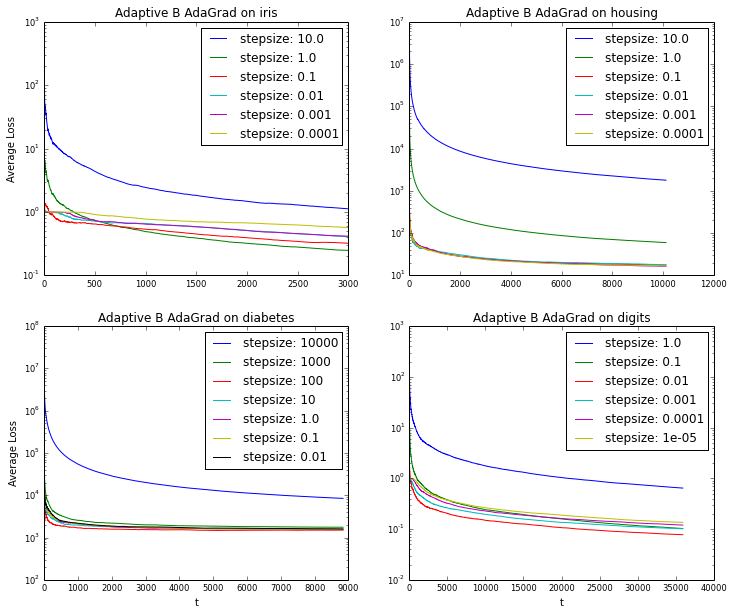

In [110]:
# <!-- collapse=True -->
plotalgorithms(datasets,[(adaBadagrad,"Adaptive B AdaGrad",adagradsteps,'red')])

There is still a step-size dependence, but now it is much more striking for the larger step sizes while all the smaller step sizes tend to do quite well. This may not be extremely clear from these graphs alone, so let's plot AdaGrad next to the Adaptive $B$ version on the same step sizes.

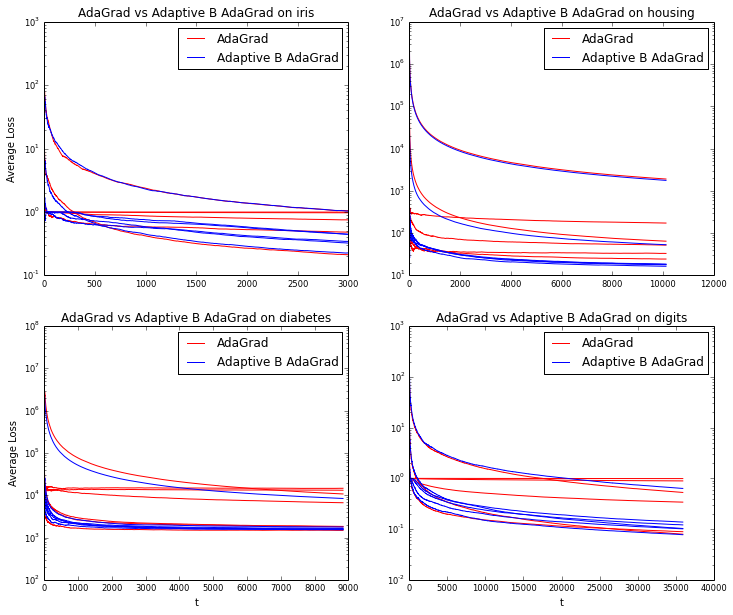

In [111]:
# <!-- collapse=True -->
plotalgorithms(datasets,[(adagrad,"AdaGrad",adagradsteps,'red'),
                         (adaBadagrad,"Adaptive B AdaGrad",adagradsteps,'blue')],steplabels=False)

From this we see adapting $B$ allows us to see low loss over a wider range of parameters. Further, we see very little degradation of results when from adapting the $B$ - it seems that our best Adaptive $B$ results are no worse than the best AdaGrad results. In particular, if one has enough time/computation to pick an optimal stepsize for AdaGrad, then applying that same effort to picking an optimal initial guess for Adaptive $B$ AdaGrad should be just as good.

This is highlighted in the plots below - we compare AdaGrad to Adaptive $B$ AdaGrad using the best parameters for each algorithm.

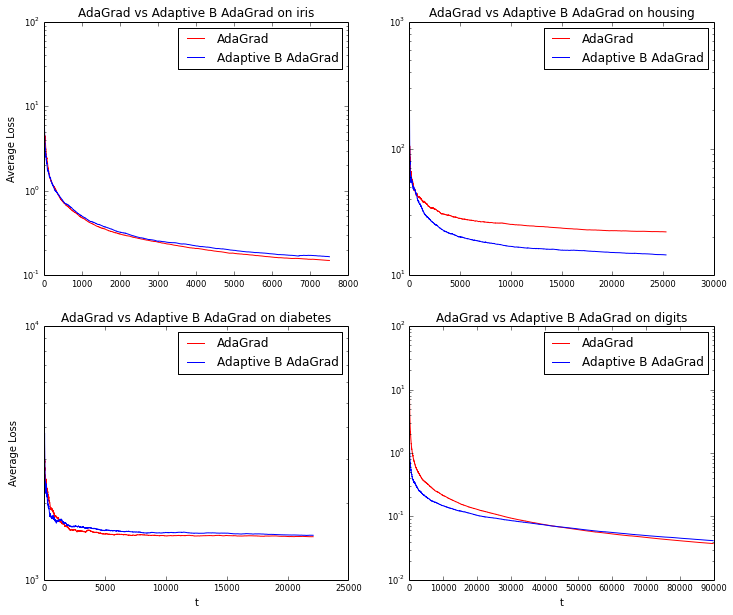

In [116]:
# <!-- collapse=True -->
adagradbest = {}
adagradbest["digits"] = [0.1]
adagradbest["iris"] = [1.0]
adagradbest["housing"] = [0.1]
adagradbest["diabetes"] = [100]

adabadagradbest = {}
adabadagradbest["digits"] = [0.01]
adabadagradbest["iris"] = [1.0]
adabadagradbest["housing"] = [0.1]
adabadagradbest["diabetes"] = [100]

plotalgorithms(datasets,[(adagrad,"AdaGrad",adagradbest,'red'),
                         (adaBadagrad,"Adaptive B AdaGrad",adabadagradbest,'blue')],steplabels=False,passes = 50)

We don't seem to be losing very much at all by adapting $B$! In fact, on the boston housing dataset we're doing a little better. This suggests that there is some imbalance in the optimal step size across dimensions - by adapting the B value for each dimension we can automatically compensate for different scalings in different dimensions.

So that is very encouraging, but the major purpose of Adaptive $B$ is that we should be able to get away with any underestimate of $B^*$. In particular, we should be able to just "guess really small" on any dataset and still do fine. In the following graphs we compare AdaGrad to Adaptive $B$ AdaGrad over a set of parameters that is held fixed across each dataset.

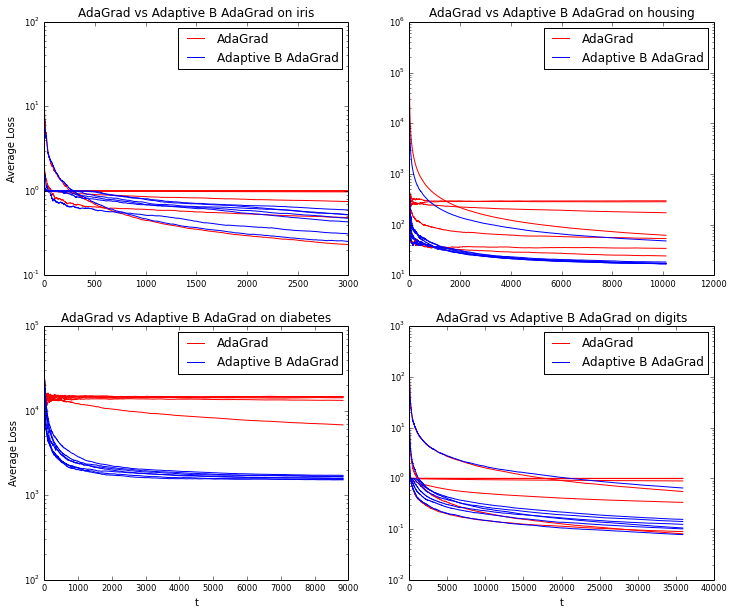

In [113]:
# <!-- collapse=True -->
common_steps = [1.0,0.1,0.01,0.001,0.0001,0.00001,0.000001]

plotalgorithms(datasets,[(adagrad,"AdaGrad",common_steps,'red'),
                         (adaBadagrad,"Adaptive B AdaGrad",common_steps,'blue')],steplabels=False)

As a conservative illustration, let's just pick a single super-safe under-estimate for $B^*$ $(0.0001)$ and compare the Adaptive $B$ AdaGrad on this fixed value to AdaGrad when we pick the best learning rate:

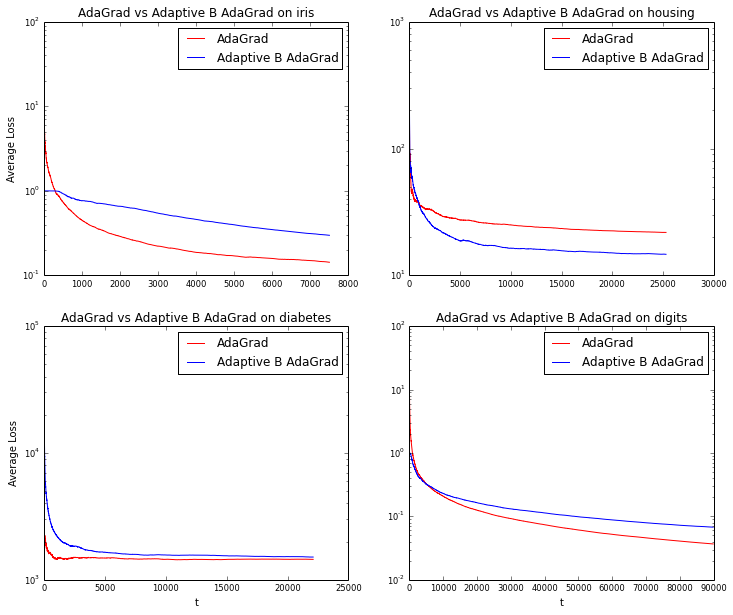

In [114]:
# <!-- collapse=False -->
adagradbest = {}
adagradbest["digits"] = [0.1]
adagradbest["iris"] = [1.0]
adagradbest["housing"] = [0.1]
adagradbest["diabetes"] = [100]

adabadagradcommon = [0.0001]

plotalgorithms(datasets,[(adagrad,"AdaGrad",adagradbest,'red'),
                         (adaBadagrad,"Adaptive B AdaGrad",adabadagradcommon,'blue')],steplabels=False,passes=50)

So as expected, AdaGrad can do better if we pick an optimal stepsize in hindsight. However, on the Boston housing data Adaptive B AdaGrad actually outperforms all AdaGrad parameter settings even when we don't try to optimize Adaptive $B$ AdaGrad. Again, this is probably due to some imbalance in scaling across dimensions.

Also, note that the AdaGrad step sizes span 4 orders of magnitude (0.1 to 100), while the Adaptive B initial step size is constant for all datasets.

If on the other hand we try to pick a constant learning rate for AdaGrad across datasets we instead get the following:

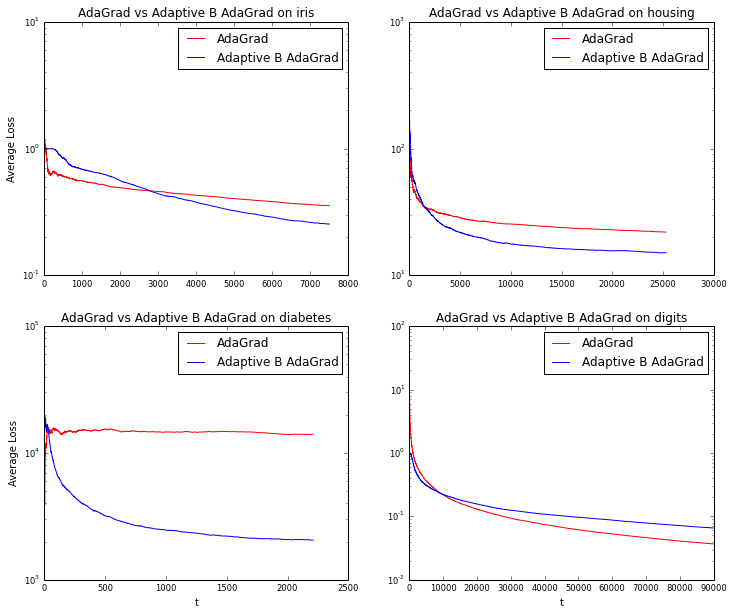

In [120]:
# <!-- collapse=True -->
adagradcommon = [0.1]
adabadagradcommon = [0.0001]

passes = {}
passes["digits"] = 50
passes["iris"] = 50
passes["housing"] = 50
passes["diabetes"] = 5

plotalgorithms(datasets,[(adagrad,"AdaGrad",adagradcommon,'red'),
                    (adaBadagrad,"Adaptive B AdaGrad",adabadagradcommon,'blue')],
                    steplabels=False,passes = passes)

Adaptive B AdaGrad is not always better than ordinary AdaGrad since we might happen to choose an optimal step size by chance, as in the case of the digits plot. However, we see that adapting the $B$ does in fact do well consistently across datasets - it is only mildly worse on digits, and it is very significantly better on diabetes. Further, to pick even this single common AdaGrad parameter I used the information gleaned from previously running AdaGrad on these datasets. That is, I picked an AdaGrad parameter that I knew ahead of time would be reasonable on many of the datasets. Thus the amount of work (both human and computer) that went into picking the common AdaGrad parameter was still significantly more than was needed for the Adaptive B AdaGrad, while the results are generally worse.


<h5>Algebra for Bound on $R_{t_1,t_2}$ in case 1:</h5>

This is just a mess of algebra for the second "Case 1" bound. It's mostly here because I wanted to write it up so that I could check myself in the process.

Recall that we had the equations
$$
R_{t_1,t_2} \le \left(\frac{(\|w^*\| + (1+\alpha)B)^2}{2 \alpha B}-\frac{(\|w^*\|-(1+2\alpha)B)^2}{2\alpha B} + \alpha B\right)L\sqrt{t_2-t_1}
$$

$$
\frac{\sigma}{2}(\|w^*\| - (1+\alpha)B)^2\sqrt{t_2-t_1} \le \left(\frac{(\|w^*\| + (1+\alpha)B)^2}{2 \alpha B}-\frac{(\|w^*\|-(1+2\alpha)B)^2}{2\alpha B} + \alpha B\right)L
$$


$$
\frac{\|w^*\|}{\|w^*\|-(1+\alpha)B} \le \frac{1}{\alpha}\\
\frac{1}{\|w^*\|-(1+\alpha)B} \le \frac{1}{\alpha B}\\
\frac{1}{\|w^*\| - (1+\alpha)B}\ge \frac{1}{\|w^*\|}
$$

Let's just work with the first equation for a minute:

$$
R_{t_1,t_2} \le \frac{L\sqrt{t_2-t_2}}{2\alpha B}\left(\w^2 +2\w(1+\alpha)B + (1+\alpha)^2 B^2 -\w^2 + 2\w(1+2\alpha)B - (1+2\alpha)^2B^2\right)+\alpha B L\sqrt{t_2-t_2}\\
=L\sqrt{t_2-t_2} \left(\frac{\w (2+3\alpha)}{\alpha} - \frac{B(2+3\alpha)}{2}\right)+\alpha BL\sqrt{t_2-t_1}
$$

Now the second equation becomes

$$
\frac{\sigma}{2}(\|w^*\| - (1+\alpha)B)^2\sqrt{t_2-t_1} \le L \left(\frac{\w (2+3\alpha)}{\alpha} - \frac{B(2+3\alpha)}{2}\right)+\alpha BL
$$

Now set 

$$
\Delta = \frac{\sigma}{2}(\|w^*\| - (1+\alpha)B)^2 = g(\w - (1+\alpha)B)
$$

so that combining our equations we have

$$
R_{t_1,t_2} \le \frac{\w^2\left(\frac{2+3\alpha}{\alpha}\right)^2L^2}{\Delta} - 2\frac{\w\left(\frac{2+3\alpha}{\alpha}\right) B \left(\frac{2+3\alpha}{2}\right)L^2}{\Delta}+2\frac{\w\left(\frac{2+3\alpha}{\alpha}\right)\alpha B L^2}{\Delta} + \frac{B^2 \left(\frac{2+3\alpha}{2}\right)^2 L^2}{\Delta} - 2\frac{B^2\frac{2+3\alpha}{2}L^2\alpha}{\Delta} + \frac{\alpha^2 B^2L^2}{\Delta}
$$

Now we have
$$
\frac{\w}{\Delta} \le \frac{1}{g\alpha}\\
-\frac{\frac{2+3\alpha}{\alpha}\w-B\alpha}{\Delta} \le -\frac{2+3\alpha}{g\alpha}-1\\
\frac{B}{\Delta} \le \frac{1}{g\alpha}
$$

so that (applying the middle inequality to our two negative terms):

$$
R_{t_1,t_2} \le \frac{\w}{g\alpha}\left(\frac{2+3\alpha}{\alpha}\right)^2 L^2 - 2\frac{\left(\frac{2+3\alpha}{\alpha}\right)\left(\frac{2+3\alpha}{2}\right)L^2B}{g}+2\frac{\w\left(\frac{2+3\alpha}{\alpha}\right)\alpha L^2}{g\alpha} +\frac{B\left(\frac{2+3\alpha}{2}\right)^2L^2}{g\alpha}-2\frac{B\left(\frac{2+3\alpha}{2}\right)L^2\alpha}{g\alpha} + \frac{\alpha BL^2}{g}
$$

And simplifying some we notice that all the terms without $\w$ add to a negative number, so that we have

$$
R_{t_1,t_2} \le \frac{\w L^2}{g}\frac{2+3\alpha}{\alpha}\left[\frac{2}{\alpha^2}+\frac{3}{\alpha}+2\right]
$$

Finally, applying $\frac{\w}{g} \le \frac{1}{\alpha}$ we achieve the expression used in the proof.

